In [64]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
import seaborn as sns

In [35]:
data = pd.read_csv('test_bitcoin.csv')
data.head()

,Unnamed: 0,asset_id,time,open,close,high,low,volume,market_cap,url_shares,...,medium,youtube,social_contributors,social_volume,price_btc,social_volume_global,social_dominance,market_cap_global,market_dominance,percent_change_24h
0,0,1,1579910400,8374.563305,8338.483527,8374.563305,8338.483527,8337279240,1.508163e+11,14526,...,NaN,NaN,26799,66250,1,293688,22.557953,2.286037e+11,65.972805,-1.059191
1,1,1,1579996800,8487.165177,8581.896879,8581.896879,8487.165177,8671821822,1.536224e+11,15653,...,NaN,NaN,24638,67404,1,282643,23.847751,2.372745e+11,64.744604,2.919156
2,2,1,1580083200,8623.902828,8869.566390,8869.566390,8623.902828,11994183173,1.584558e+11,23000,...,NaN,NaN,26381,95172,1,359881,26.445408,2.439090e+11,64.965124,3.352050
3,3,1,1580169600,8961.291095,9351.783109,9351.783109,8961.291095,15305415703,1.639961e+11,21690,...,NaN,NaN,19196,103863,1,367873,28.233385,2.551600e+11,64.271886,5.436756
4,4,1,1580256000,9303.009612,9259.615291,9303.009612,9217.970302,14233710766,1.683224e+11,21249,...,NaN,NaN,39412,92038,1,332949,27.643273,2.532066e+11,66.476298,-0.985564


In [36]:
data = data[['time', 'open', 'close', 'high', 'low', 'volume', 'market_cap']]

In [37]:
data.head()

,time,open,close,high,low,volume,market_cap
0,1579910400,8374.563305,8338.483527,8374.563305,8338.483527,8337279240,1.508163e+11
1,1579996800,8487.165177,8581.896879,8581.896879,8487.165177,8671821822,1.536224e+11
2,1580083200,8623.902828,8869.566390,8869.566390,8623.902828,11994183173,1.584558e+11
3,1580169600,8961.291095,9351.783109,9351.783109,8961.291095,15305415703,1.639961e+11
4,1580256000,9303.009612,9259.615291,9303.009612,9217.970302,14233710766,1.683224e+11


In [42]:
data['time'] = data['time'].apply(lambda x : (datetime.fromtimestamp(x) - timedelta(hours=2)).strftime('%Y-%m-%d'))

In [45]:
data = data.sort_values('time')
data.head()

,time,open,close,high,low,volume,market_cap
0,2020-01-24,8374.563305,8338.483527,8374.563305,8338.483527,8337279240,1.508163e+11
1,2020-01-25,8487.165177,8581.896879,8581.896879,8487.165177,8671821822,1.536224e+11
2,2020-01-26,8623.902828,8869.566390,8869.566390,8623.902828,11994183173,1.584558e+11
3,2020-01-27,8961.291095,9351.783109,9351.783109,8961.291095,15305415703,1.639961e+11
4,2020-01-28,9303.009612,9259.615291,9303.009612,9217.970302,14233710766,1.683224e+11


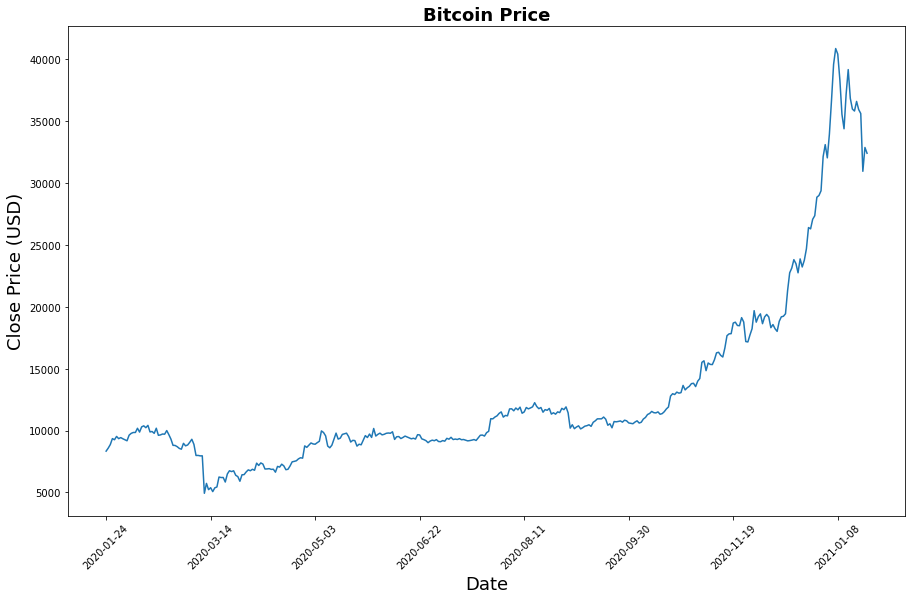

In [47]:
price = data[['close']]

plt.figure(figsize = (15,9))
plt.plot(price)
plt.xticks(range(0, data.shape[0],50), data['time'].loc[::50],rotation=45)
plt.title("Bitcoin Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [49]:
#Normalization

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

norm_data = min_max_scaler.fit_transform(price.values)

In [52]:
print(f'Real: {price.values[0]}, Normalized: {norm_data[0]}')
print(f'Real: {price.values[100]}, Normalized: {norm_data[100]}')
print(f'Real: {price.values[300]}, Normalized: {norm_data[300]}')

Real: [8338.483527], Normalized: [0.09480135]
Real: [8896.347032], Normalized: [0.1103168]
Real: [18693.123217], Normalized: [0.38278732]


In [53]:
# Data split 
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

past_history = 5
future_target = 0

TRAIN_SPLIT = int(len(norm_data) * 0.8)


x_train, y_train = univariate_data(norm_data,
                                   0,
                                   TRAIN_SPLIT,
                                   past_history,
                                   future_target)

x_test, y_test = univariate_data(norm_data,
                                 TRAIN_SPLIT,
                                 None,
                                 past_history,
                                 future_target)

In [66]:

from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, LSTM, LeakyReLU, Dropout

num_units = 30
learning_rate = 0.0001
activation_function = 'sigmoid'
adam = Adam(lr=learning_rate)
loss_function = 'mse'
batch_size = 5
num_epochs = 50

# Initialize the RNN
model = Sequential()
model.add(LSTM(units = num_units, activation=activation_function, input_shape=(None, 1)))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.1))
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer=adam, loss=loss_function)

In [67]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 30)                3840      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 30)                0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 31        
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


In [68]:
# Using the training set to train the model
history = model.fit(
    x_train,
    y_train,
    validation_split=0.1,
    batch_size=batch_size,
    epochs=num_epochs,
    shuffle=False
)

Epoch 1/50
52/52 [==============================] - 2s 13ms/step - loss: 1.1335 - val_loss: 1.1011
Epoch 2/50
52/52 [==============================] - 0s 5ms/step - loss: 0.8122 - val_loss: 0.8158
Epoch 3/50
52/52 [==============================] - 0s 4ms/step - loss: 0.5976 - val_loss: 0.5995
Epoch 4/50
52/52 [==============================] - 0s 5ms/step - loss: 0.4310 - val_loss: 0.4340
Epoch 5/50
52/52 [==============================] - 0s 6ms/step - loss: 0.2833 - val_loss: 0.3110
Epoch 6/50
52/52 [==============================] - 0s 8ms/step - loss: 0.2010 - val_loss: 0.2173
Epoch 7/50
52/52 [==============================] - 1s 10ms/step - loss: 0.1410 - val_loss: 0.1494
Epoch 8/50
52/52 [==============================] - 1s 13ms/step - loss: 0.0860 - val_loss: 0.1020
Epoch 9/50
52/52 [==============================] - 1s 15ms/step - loss: 0.0664 - val_loss: 0.0685
Epoch 10/50
52/52 [==============================] - 1s 10ms/step - loss: 0.0509 - val_loss: 0.0488
Epoch 11/50
52

[Text(-10.0, 0, ''),
 Text(0.0, 0, ''),
 Text(10.0, 0, ''),
 Text(20.0, 0, ''),
 Text(30.0, 0, ''),
 Text(40.0, 0, ''),
 Text(50.0, 0, ''),
 Text(60.0, 0, ''),
 Text(70.0, 0, ''),
 Text(80.0, 0, '')]

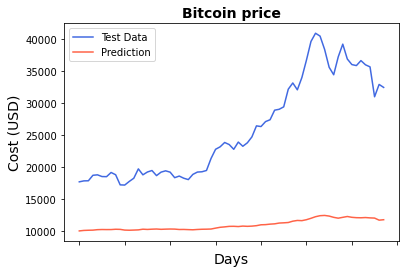

In [69]:
original = pd.DataFrame(min_max_scaler.inverse_transform(y_test))
predictions = pd.DataFrame(min_max_scaler.inverse_transform(model.predict(x_test)))

ax = sns.lineplot(x=original.index, y=original[0], label="Test Data", color='royalblue')
ax = sns.lineplot(x=predictions.index, y=predictions[0], label="Prediction", color='tomato')
ax.set_title('Bitcoin price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)